In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png


[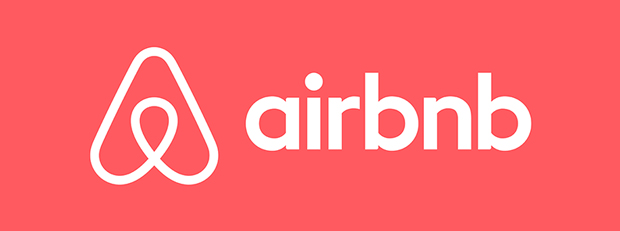]

 # Business Problem

1. What can we learn about different hosts and areas?
2. What can we learn from predictions? (ex: locations, prices, reviews, etc)
3. Which hosts are the busiest and why?
4. Is there any noticeable difference of traffic among different areas and what could be the reason for it?

# STEP 1 : Importing Libraries 

In [2]:
pip install pandas-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.2 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas_profiling import ProfileReport

import folium
from folium.plugins import MarkerCluster
from folium import plugins
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

/tmp/ipykernel_17/2549341784.py:25: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


# STEP 2 : Adjusting the Row Column Settings

In [4]:
# Set display options
pd.set_option('display.max_columns', None)    # Display all columns
# pd.set_option('display.max_rows', None)     # Uncomment to display all rows
pd.set_option('display.width', None)           # Set display width to None
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format float to 3 decimal places

# STEP 3 : Data Loading

In [5]:
df = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

# STEP 4 : Data Understanding

In [6]:
df.shape

(48895, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [8]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647,-73.972,Private room,149,1,9,2018-10-19,0.210,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.754,-73.984,Entire home/apt,225,1,45,2019-05-21,0.380,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809,-73.942,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.685,-73.960,Entire home/apt,89,1,270,2019-07-05,4.640,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.799,-73.944,Entire home/apt,80,10,9,2018-11-19,0.100,1,0


In [9]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
id,48895.000,19017143.236,10983108.386,2539.000,9471945.000,19677284.000,29152178.500,36487245.000
host_id,48895.000,67620010.647,78610967.033,2438.000,7822033.000,30793816.000,107434423.000,274321313.000
latitude,48895.000,40.729,0.055,40.500,40.690,40.723,40.763,40.913
longitude,48895.000,-73.952,0.046,-74.244,-73.983,-73.956,-73.936,-73.713
price,48895.000,152.721,240.154,0.000,69.000,106.000,175.000,10000.000
minimum_nights,48895.000,7.030,20.511,1.000,1.000,3.000,5.000,1250.000
number_of_reviews,48895.000,23.274,44.551,0.000,1.000,5.000,24.000,629.000
reviews_per_month,38843.000,1.373,1.680,0.010,0.190,0.720,2.020,58.500
calculated_host_listings_count,48895.000,7.144,32.953,1.000,1.000,1.000,2.000,327.000
availability_365,48895.000,112.781,131.622,0.000,0.000,45.000,227.000,365.000


# STEP 5 : Data Cleaning

In [10]:
# Counting Null Values
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [11]:
# Counting Duplicates
duplicate_count = df.duplicated().sum()

print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 0


In [12]:
# Dropping unwanted columns from the dataset

drop_list = ['id', 'host_id', 'host_name', "last_review"]
df.drop(drop_list, axis=1, inplace=True)

In [13]:
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.647,-73.972,Private room,149,1,9,0.210,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.754,-73.984,Entire home/apt,225,1,45,0.380,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.809,-73.942,Private room,150,3,0,NaN,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.685,-73.960,Entire home/apt,89,1,270,4.640,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.799,-73.944,Entire home/apt,80,10,9,0.100,1,0
